# Data Preparation

In [34]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Defining a base neural network

In [35]:
class BaseNeuralNetwork(nn.Module):
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        # Flatten inputs
        #self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Linear(26,416), 
            nn.ReLU(),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = BaseNeuralNetwork()

In [102]:
class BaseNeuralNetwork(nn.Module):
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        # Flatten inputs
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.ReLU(),
                nn.Linear(512,256),
                nn.ReLU(),
                nn.Linear(256,128),
                nn.ReLU(),
                nn.Linear(128,64),
                nn.ReLU(),
                nn.Linear(64,32),
                nn.ReLU(),
                nn.Linear(32,16),
                nn.ReLU(),
                nn.Linear(16,10)
            
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = BaseNeuralNetwork()

In [163]:
def train_loop(dataloader, model, loss_fn, optimizer, prin = False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation (always in three steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0 and prin:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return 100*(1-correct)

### Learning

In [104]:
# Hyperparameters
learning_rate = 0.001
batch_size = 256
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [105]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [106]:
### Training
error = []
for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    #Use train_loop and test_loop functions
    train_loop(train_dataloader, model, loss_fn, optimizer)
    x = test_loop(test_dataloader, model, loss_fn)
    error.append(x)
print("Done!")


Epoch 1-----------------
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.563955
Epoch 2-----------------
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.470518
Epoch 3-----------------
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.433033
Epoch 4-----------------
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.406194
Epoch 5-----------------
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.389415
Epoch 6-----------------
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.375461
Epoch 7-----------------
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.370210
Epoch 8-----------------
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.382567
Epoch 9-----------------
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.367546
Epoch 10-----------------
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.360022
Done!


In [107]:
class BaseNeuralNetworkRS(nn.Module):
    def __init__(self):
        super(BaseNeuralNetworkRS, self).__init__()
        # Flatten inputs
        self.flatten = nn.Flatten()

        self.relu = nn.ReLU()

        self.start = nn.Linear(28 * 28, 512)
        self.lin1 = nn.Linear(512,256)
        self.lin2 = nn.Linear(256,128)
        self.lin3 = nn.Linear(128,64)
        self.lin4 = nn.Linear(64,32)
        self.lin5 = nn.Linear(32,16)
        self.fc = nn.Linear(16,10)
        
    def proj(self, x, size):
        indice = np.linspace(0, size - 1, size).tolist()
        indice = torch.tensor([int(x) for x in indice])
        
        return torch.index_select(x, 1, indice)


    def forward(self, x):
        x = self.flatten(x)
        f = 0
        x = self.relu(self.start(x)) + f*self.proj(x, 512)
        x = self.relu(self.lin1(x)) + f*self.proj(x, 256)
        x = self.relu(self.lin2(x)) + f*self.proj(x, 128)
        x = self.relu(self.lin3(x)) + f*self.proj(x, 64)
        x = self.relu(self.lin4(x)) + f*self.proj(x, 32)
        x = self.relu(self.lin5(x)) + f*self.proj(x, 16)
        x = self.relu(self.fc(x))

        return x

modelRS = BaseNeuralNetworkRS()

In [108]:
### Training
error = []
for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    #Use train_loop and test_loop functions
    train_loop(train_dataloader, modelRS, loss_fn, optimizer)
    x = test_loop(test_dataloader, model, loss_fn)
    error.append(x)
print("Done!")


Epoch 1-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 2-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 3-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 4-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 5-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 6-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 7-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 8-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 9-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 10-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Done!


[24.750000000000007, 17.830000000000002, 15.239999999999998, 14.459999999999996, 14.359999999999996, 13.81, 13.770000000000005, 13.090000000000002, 12.9, 12.490000000000002]


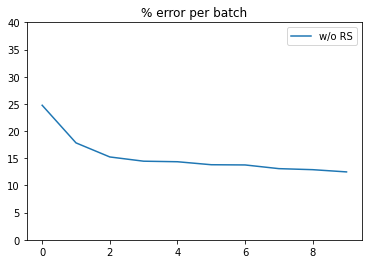

In [60]:
import copy

error_wo = copy.deepcopy(error)

plt.plot(error_wo, label = "w/o RS")
plt.legend()
plt.title("% error per batch")
plt.ylim((0, 40))
plt.show()

Using Conv2D

In [206]:
class BaseNeuralNetwork(nn.Module):
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten() # Flatten inputs
        self.conv_stack = nn.Sequential(
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                           
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2, ),     
            nn.ReLU(),                                     
        )

        self.output_stack = nn.Sequential(
            nn.Linear(32 * 28 * 28, 10)
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.conv_stack(x) 
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        logits = logits.view(logits.size(0), -1)
        logits = self.output_stack(logits)
        return logits

model = BaseNeuralNetwork()



In [136]:
learning_rate = 1e-3
batch_size = 64
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [207]:
### Training
error_wo = []
for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    #Use train_loop and test_loop functions
    learning_rate = 0.01/(t+1)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loop(train_dataloader, model, loss_fn, optimizer, prin = True)
    x = test_loop(test_dataloader, model, loss_fn)
    error_wo.append(x)
print("Done!")


Epoch 1-----------------
loss: 2.300387  [    0/60000]
loss: 0.330322  [25600/60000]
loss: 0.329241  [51200/60000]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.345539
Epoch 2-----------------
loss: 0.275289  [    0/60000]
loss: 0.269909  [25600/60000]
loss: 0.243078  [51200/60000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.302817
Epoch 3-----------------
loss: 0.185699  [    0/60000]
loss: 0.232983  [25600/60000]
loss: 0.192686  [51200/60000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.286924
Epoch 4-----------------
loss: 0.135113  [    0/60000]
loss: 0.203886  [25600/60000]
loss: 0.151900  [51200/60000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.279495
Epoch 5-----------------
loss: 0.100060  [    0/60000]
loss: 0.186171  [25600/60000]
loss: 0.126516  [51200/60000]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.279829
Epoch 6-----------------
loss: 0.080773  [    0/60000]
loss: 0.170438  [25600/60000]
loss: 0.110165  [51200/60000]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.287763
Epoch 7---

Trying RS


In [201]:
class BaseNeuralNetwork(nn.Module):
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten() # Flatten inputs
        self.conv_stack = nn.Sequential(
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                           
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2, ),                                     
        )

        self.output_stack = nn.Sequential(
            nn.Linear(32 * 28 * 28, 10)
        )

    def proj(self, x, size):
        indice = np.linspace(0, size - 1, size).tolist()
        indice = torch.tensor([int(x) for x in indice])
        res = torch.index_select(x, 3, indice)
        res = torch.index_select(res, 2, indice)
        return res

    def forward(self, x):
        #x = self.flatten(x)

        logits = self.conv_stack(x) + x
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        logits = logits.view(logits.size(0), -1)
        logits = self.output_stack(logits)
        return logits

model = BaseNeuralNetwork()



In [202]:
# Hyperparameters
learning_rate = 0.01
batch_size = 256
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [203]:
### Training
error_w = []
for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    #Use train_loop and test_loop functions
    learning_rate = 0.01/(t+1)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loop(train_dataloader, model, loss_fn, optimizer, prin = True)
    x = test_loop(test_dataloader, model, loss_fn)
    error_w.append(x)
print("Done!")


Epoch 1-----------------
loss: 2.379060  [    0/60000]
loss: 0.907272  [25600/60000]
loss: 0.694651  [51200/60000]
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.789519
Epoch 2-----------------
loss: 0.750633  [    0/60000]
loss: 0.637622  [25600/60000]
loss: 0.648334  [51200/60000]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.613266
Epoch 3-----------------
loss: 0.528052  [    0/60000]
loss: 0.550186  [25600/60000]
loss: 0.403670  [51200/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.479370
Epoch 4-----------------
loss: 0.336317  [    0/60000]
loss: 0.372423  [25600/60000]
loss: 0.287402  [51200/60000]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.398178
Epoch 5-----------------
loss: 0.226613  [    0/60000]
loss: 0.267910  [25600/60000]
loss: 0.272990  [51200/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.405756
Epoch 6-----------------
loss: 0.201502  [    0/60000]
loss: 0.245829  [25600/60000]
loss: 0.281266  [51200/60000]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.385216
Epoch 7---

In [204]:
error_w = copy.deepcopy(error)

Plotting results

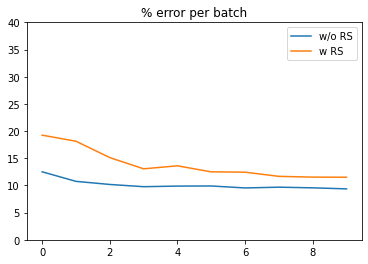

In [208]:
plt.plot(error_wo, label = "w/o RS")
plt.plot(error_w, label = "w RS")
plt.legend()
plt.title("% error per batch")
plt.ylim((0, 40))
plt.show()